# FACTORS INFLUENCING STROKE

This notebook combines python and R codes. I prefer doing things like data wrangling in R than python. 

In [1]:
import os          
import tarfile
from six.moves import urllib
import pandas as pd
import numpy as np
from pandas.plotting import scatter_matrix
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_val_predict
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
#import sklearn.linear_model as lm
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.base import clone, BaseEstimator, TransformerMixin
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, precision_recall_curve
from sklearn.metrics import recall_score, precision_recall_curve, roc_auc_score, f1_score, roc_curve, auc
from xgboost import XGBClassifier, plot_importance
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import category_encoders as ce



%matplotlib inline 
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')



In [2]:
%load_ext rpy2.ipython

In [3]:
%%R
library(tidyverse)
library(cowplot)

R[write to console]: Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

R[write to console]: Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

R[write to console]: ✔ ggplot2 3.1.1     ✔ purrr   0.3.2
✔ tibble  2.1.1     ✔ dplyr   0.8.3
✔ tidyr   1.0.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

R[write to console]: 
********************************************************

R[write to console]: Note: As of version 1.0.0, cowplot does not change the

R[write to console]:   default ggplot2 theme anymore. To recover the previous

R[write to console]:   behavior, exe

## Import and investigating the training data

In [4]:
%%R 
train = read.csv("./healthcare-dataset-stroke-data/train_2v.csv", stringsAsFactors=FALSE)
summary(train)
sum(train$stroke)

[1] 783


In [5]:
train = %R train
print("The dimenssion of the training set is ", train.shape)
train.head()

The dimenssion of the training set is  (43400, 12)


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1,30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,,0
2,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
3,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,,0
4,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
5,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,,0


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43400 entries, 1 to 43400
Data columns (total 12 columns):
id                   43400 non-null int32
gender               43400 non-null object
age                  43400 non-null float64
hypertension         43400 non-null int32
heart_disease        43400 non-null int32
ever_married         43400 non-null object
work_type            43400 non-null object
Residence_type       43400 non-null object
avg_glucose_level    43400 non-null float64
bmi                  41938 non-null float64
smoking_status       43400 non-null object
stroke               43400 non-null int32
dtypes: float64(3), int32(4), object(5)
memory usage: 3.6+ MB


## Data Visualisation

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbfa81f6748>,
      dtype=object)

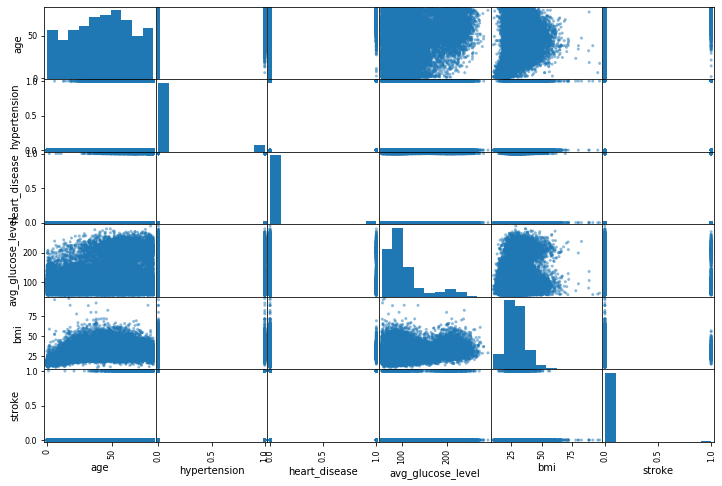

In [7]:
scatter_matrix(train.drop("id",axis=1), figsize=(12, 8))

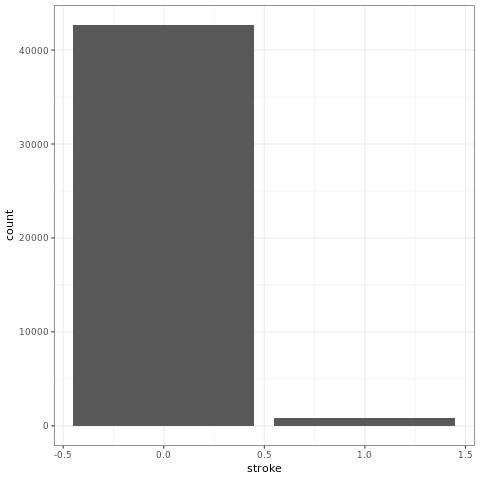

In [7]:
%%R
train%>%ggplot(aes(stroke)) + geom_bar() + theme_bw()

Text(0.5, 1.0, 'Target variable count')

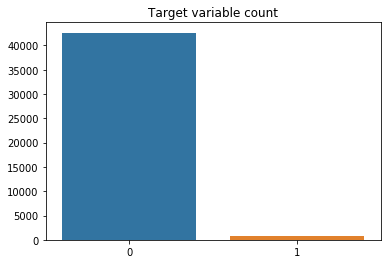

In [8]:
x=train['stroke'].value_counts().values
sns.barplot([0,1],x)
plt.title('Target variable count')

Notice a few things in the histograms (on the diagonal fot the first graph):
1. First, the stroke attribute shows that a large number of indivuduals sampled were not affected by stroke. Only aproximatively 2% were affected by stroke. This is an imbalanced class data.
2. Attributes have different scales. 
3. Historgrams such as that of average glucose level's attribute is tail heavy: it extend much farther to the right of the median thant to the left. This may make it a vit harder for some ML algotithms to detect patterns.

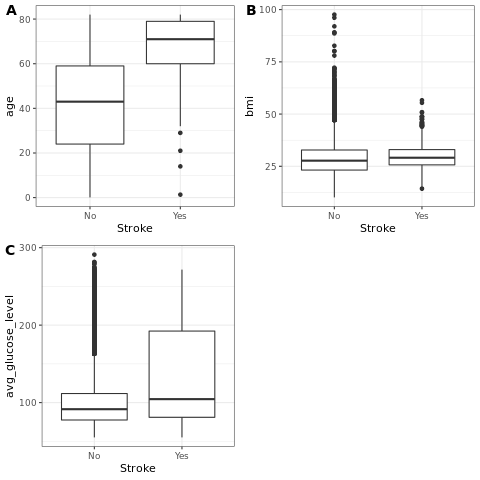

In [9]:
%%R

age_plot <- train%>%ggplot(aes(as.factor(stroke),age)) + geom_boxplot() + theme_bw() + scale_x_discrete(breaks=c(0, 1), labels=c('No', "Yes")) + xlab("Stroke")
bmi_plot <- train%>%ggplot(aes(as.factor(stroke),bmi)) + geom_boxplot() + theme_bw() + scale_x_discrete(breaks=c(0, 1), labels=c('No', "Yes")) + xlab("Stroke")
avg_glu_plot <- train%>%ggplot(aes(as.factor(stroke),avg_glucose_level)) + geom_boxplot() + theme_bw() + scale_x_discrete(breaks=c(0, 1), labels=c('No', "Yes")) + xlab("Stroke")
plot_grid(age_plot, bmi_plot, avg_glu_plot, labels = "AUTO")

A quick look at these boxplots reveals that stroke is likekely to affect older people i.e. age seems to influence stroke. Both bmi and avg_glucose_level attribute however do not seem to have a significant influence on stroke occurence as both median (No and Yes) do not appear to be statistically different. 

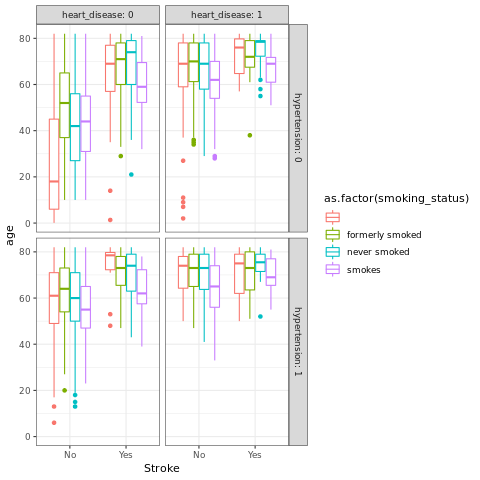

In [11]:
%%R

age_smo <- ggplot(train, aes(x=as.factor(stroke), y=age, color=as.factor(smoking_status))) + geom_boxplot()+ 
    facet_grid(hypertension ~ heart_disease,labeller = labeller(.rows = label_both, .cols = label_both))+
    theme_bw() + scale_x_discrete(breaks=c(0, 1), labels=c('No', "Yes")) + xlab("Stroke")
age_smo

Upper left panel shows that smoking, heart disease and hypertension do not significantly influence the occurance of stroke as among those affected by stroke. Among the subset affected by stroke, the median of those never smoked is comparable with those formerly smoked but suprisely, exceeds that of those who smoke. This is probably due to the missing information on the smoking_status attribute.

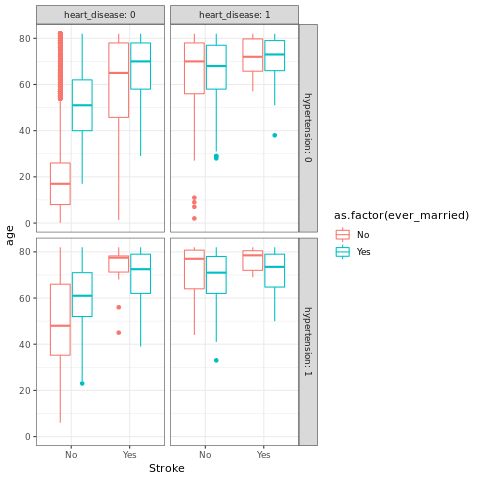

In [30]:
%%R

age_maried <- ggplot(train, aes(x=as.factor(stroke), y=age, color=as.factor(ever_married))) + geom_boxplot()+ 
    facet_grid(hypertension ~ heart_disease,labeller = labeller(.rows = label_both, .cols = label_both))+
    theme_bw() + scale_x_discrete(breaks=c(0, 1), labels=c('No', "Yes")) + xlab("Stroke")
    
age_maried

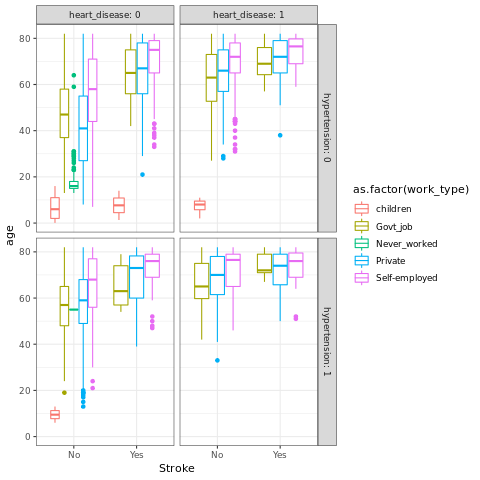

In [32]:
%%R

age_wor_typ <- ggplot(train, aes(x=as.factor(stroke), y=age, color=as.factor(work_type))) + geom_boxplot()+ 
    facet_grid(hypertension ~ heart_disease,labeller = labeller(.rows = label_both, .cols = label_both))+
    theme_bw() + scale_x_discrete(breaks=c(0, 1), labels=c('No', "Yes")) + xlab("Stroke")
age_wor_typ

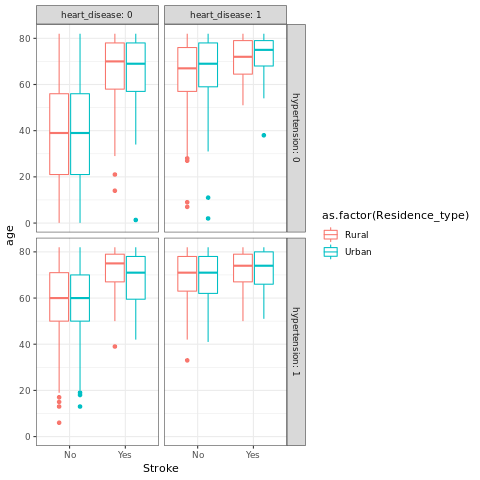

In [33]:
%%R

age_resi_typ <- ggplot(train, aes(x=as.factor(stroke), y=age, color=as.factor(Residence_type))) + geom_boxplot()+ 
    facet_grid(hypertension ~ heart_disease,labeller = labeller(.rows = label_both, .cols = label_both))+
    theme_bw() + scale_x_discrete(breaks=c(0, 1), labels=c('No', "Yes")) + xlab("Stroke")
age_resi_typ

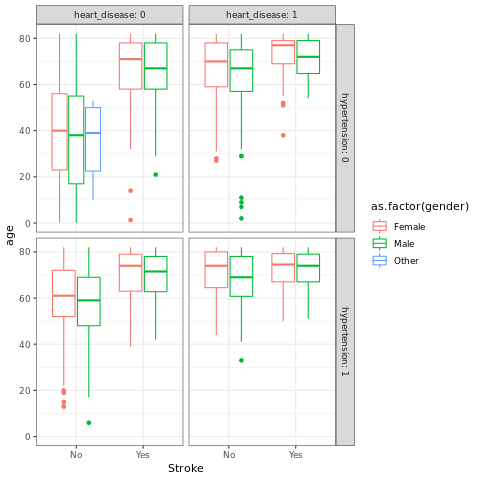

In [34]:
%%R

age_gender <- ggplot(train, aes(x=as.factor(stroke), y=age, color=as.factor(gender))) + geom_boxplot()+ 
    facet_grid(hypertension ~ heart_disease,labeller = labeller(.rows = label_both, .cols = label_both))+
    theme_bw() + scale_x_discrete(breaks=c(0, 1), labels=c('No', "Yes")) + xlab("Stroke")
age_gender

## Preparing the data for ML algorithm
- Checking for missing values

In [9]:
missing_val_prop_by_column = (train.isnull().sum()/train.shape[0])
print(missing_val_prop_by_column[missing_val_prop_by_column > 0])
missing_val_prop_by_column.index

bmi    0.033687
dtype: float64


Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

Athough smoking is a major risk factors for stroke, more than 20% of the corresponding values in the data here are missing. In the absence of any information, I assume that under 18 years old are classified as *never somoke*, 18-45 smokes and >45 formerly smoked. A thorough analysis could be considered using information from different sources.

In [10]:
%%R
fill_missing_smoking_status <- function(age,smoking_status){
    
     smoking_status<- replace(smoking_status, age<18 & smoking_status=="", "never smoke")
     smoking_status<- replace(smoking_status, age>=18 & age <45 & smoking_status=="", "smokes")
     smoking_status<- replace(smoking_status, age>= 45 & smoking_status=="", "formerly smoked")
     return(smoking_status)
}
train_update <- train%>%dplyr::mutate(smoking_status=fill_missing_smoking_status(age,smoking_status) )%>%
        as.data.frame()
head(train_update)

     id gender age hypertension heart_disease ever_married    work_type
1 30669   Male   3            0             0           No     children
2 30468   Male  58            1             0          Yes      Private
3 16523 Female   8            0             0           No      Private
4 56543 Female  70            0             0          Yes      Private
5 46136   Male  14            0             0           No Never_worked
6 32257 Female  47            0             0          Yes      Private
  Residence_type avg_glucose_level  bmi  smoking_status stroke
1          Rural             95.12 18.0     never smoke      0
2          Urban             87.96 39.2    never smoked      0
3          Urban            110.89 17.6     never smoke      0
4          Rural             69.04 35.9 formerly smoked      0
5          Rural            161.28 19.1     never smoke      0
6          Urban            210.95 50.1 formerly smoked      0


In [11]:
train_update = %R train_update
stroke_labels = train_update["stroke"]
stroke_predictors = train_update.drop(["stroke","id"], axis=1)

Remove columns with more than 10 factors (for convenience, if such columns exist, to avoid encreasing too much the size of variables after OneHotEncoding) and selecting numeric variables

In [12]:
low_cardinality_cols = [cname for cname in stroke_predictors.columns if 
                                stroke_predictors[cname].nunique() < 10 and
                                stroke_predictors[cname].dtype == "object"]
numeric_cols = [cname for cname in stroke_predictors.columns if 
                                stroke_predictors[cname].dtype in ['int64', 'float64']]

## Transformation Pipelines
Recall that the body mass index (bmi) is the only numerical attribute with missing values. I use median to fill in these gaps. The 

In [13]:
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("std_scaler", StandardScaler()),
])

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, numeric_cols),
    ("cat", OneHotEncoder(), low_cardinality_cols),
])

stroke_prepared = full_pipeline.fit_transform(train_update[low_cardinality_cols + numeric_cols])
stroke_prepared.shape

(43400, 19)

## Generate samples to account for the issue of unbalanced class

In [14]:
class OverUnderSampling(BaseEstimator, TransformerMixin):
    """
    A short transformer to generate new samples 
    in the classes which are under-represented/over-represented.
    We use randomly sampling with replacement and 
    Synthetic Minority Oversampling Technique (SMOTE).
    """
    def __init__(self, smote = True, over = True):
        self.smote = smote
        self.over = over
    def fit(sel, X, y=None):
        return self
    def transform(self, X, y=None):
        if self.over:
            if self.smote:
                X_resampled, y_resampled = SMOTE().fit_resample(X, y)
                return X_resampled, y_resampled
            else:
                ros = RandomOverSampler(random_state=0)
                X_resampled, y_resampled = ros.fit_resample(X,y)
                return X_resampled, y_resampled
        else:
            rus = RandomUnderSampler(random_state=0, replacement=True)
            X_resampled, y_resampled = rus.fit_resample(X, y)
            return X_resampled, y_resampled
            

In [15]:
 over_samp = OverUnderSampling()
 X, y = over_samp.transform(stroke_prepared, stroke_labels)

## Splitting the data into training and validation sets

In [19]:
X, X_val, y, y_val = train_test_split(stroke_prepared, stroke_labels, test_size=0.33, random_state=42)
type(X_val)

numpy.ndarray

In [26]:
%%R -i X
xx <- X
X1 <- as.data.frame(xx)

In [27]:
%%R -i X_val
yy <- X_val
X2 <- as.data.frame(yy)

In [28]:
X = %R X1
X_val = %R X2
X_train = X
y_train = y

**Using techniques to deal with imbalanced data developped [here](https://www.kaggle.com/npramod/techniques-to-deal-with-imbalanced-data):**

In [17]:
def benchmark(sampling_type,X,y):
    lr = LogisticRegression(penalty = 'l1')
    param_grid = {'C':[0.01,0.1,1,10]}
    gs = GridSearchCV(estimator=lr, param_grid=param_grid, scoring='accuracy', cv=5, verbose=2)
    gs = gs.fit(X.values,y.values.ravel())
    return sampling_type,gs.best_score_,gs.best_params_['C']

def transform(transformer,X,y):
    print("Transforming {}".format(transformer.__class__.__name__))
    X_resampled,y_resampled = transformer.fit_sample(X.values,y.values.ravel())
    return transformer.__class__.__name__,pd.DataFrame(X_resampled), pd.DataFrame(y_resampled)

In [18]:
datasets = []
datasets.append(("base",X_train,y_train))
datasets.append(transform(SMOTE(n_jobs=-1),X_train,y_train))
datasets.append(transform(RandomOverSampler(),X,y))
datasets.append(transform(RandomUnderSampler(),X_train,y_train))

Transforming SMOTE
Transforming RandomOverSampler
Transforming RandomUnderSampler


In [44]:
# benchmark_scores = []
# for sample_type,X,y in datasets:
#     print('______________________________________________________________')
#     print('{}'.format(sample_type))
#     benchmark_scores.append(benchmark(sample_type,X,y))
#     print('______________________________________________________________')

## XGBoost classifier

### Using cross validation

In [29]:
import xgboost as xgb
xg_train = xgb.DMatrix(X, label=y);
param = {'max_depth':5, 'eta':0.02, 'silent':1, 'objective':'binary:logistic'}
num_round = 5000
early_stopping = 5

def fpreproc(dtrain, dtest, param):
    label = dtrain.get_label()
    ratio = float(np.sum(label == 0)) / np.sum(label == 1)
    param['scale_pos_weight'] = ratio
    return (dtrain, dtest, param)

cv_results = xgb.cv(param, xg_train, num_round, nfold=5,
       metrics={'auc'}, seed=0, fpreproc=fpreproc, early_stopping_rounds=early_stopping)

print((cv_results))

    train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0         0.873571       0.002550       0.829633      0.017919
1         0.875479       0.003670       0.828102      0.019111
2         0.876714       0.003054       0.831850      0.018267
3         0.879399       0.002862       0.830918      0.020538
4         0.879716       0.002878       0.831904      0.018562
5         0.881182       0.003020       0.832308      0.021094
6         0.881746       0.002953       0.832401      0.020265
7         0.882658       0.003636       0.834628      0.019093
8         0.882996       0.003454       0.835239      0.018093
9         0.883924       0.003404       0.834934      0.019242
10        0.885203       0.003191       0.837258      0.017549
11        0.885773       0.003271       0.837891      0.018407
12        0.886563       0.003255       0.838520      0.017633
13        0.887167       0.002805       0.838766      0.017349
14        0.887796       0.002875       0.838766      0

In [30]:
xgb_clf = xgb.train(param, xg_train)


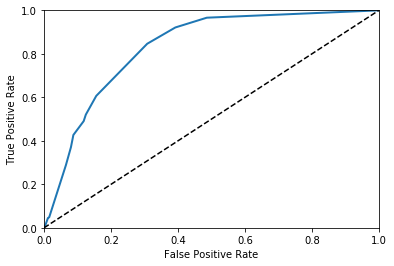

In [31]:
xg_val = xgb.DMatrix(X_val)
y_pred = xgb_clf.predict(xg_val)
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(fpr, tpr)
plt.show()

In [32]:
feature_importances = xgb_clf.get_score(importance_type='gain')
print(feature_importances)
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.get_feature_names(input_features=low_cardinality_cols))
attributes = numeric_cols + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)
# xgb_clf.feature_names = attributes
# plot_importance(xgb_clf)
# plt.show()


{'V1': 19.366617833333333, 'V2': 1.7737889311224486, 'V3': 1.2425963765115386}


[('V3', 'bmi'), ('V2', 'avg_glucose_level'), ('V1', 'age')]

### Using grid search to find optimal parameters

In [33]:
gbm_param_grid = {
    'n_estimators': [10,20],
    'max_depth': range(2, 12),
    'eta': [0.01, 0.02,0.05]
}
# Instantiate the regressor: gbm
gbm = XGBClassifier(n_estimators=10, scale_pos_weight = float(np.sum(y == 0)) / np.sum(y == 1), num_round=5000, seed=0, early_stoping=5, silent=1, 
    objective='binary:logistic')
# gbm = RandomForestClassifier(class_weight="balanced")
# Perform random search: grid_search
grid_search = RandomizedSearchCV(param_distributions=gbm_param_grid, estimator=gbm, scoring="roc_auc", n_iter=5, cv=5, verbose=1)
# Fit grid_search to the data
grid_search.fit(X, y)
# Print the best parameters and highest auc
print("Best parameters found: ", grid_search.best_params_)
print("Highest AUC found: ", grid_search.best_score_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   26.9s finished


Best parameters found:  {'n_estimators': 10, 'max_depth': 3, 'eta': 0.05}
Highest AUC found:  0.8429806289602233


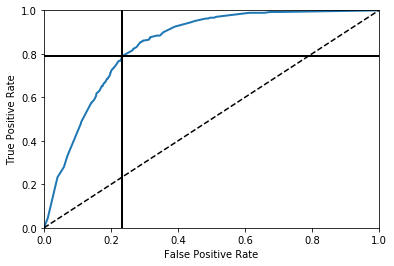

In [35]:
final_model = grid_search.best_estimator_
y_prob = final_model.predict_proba(X_val)

fpr, tpr, thresholds = roc_curve(y_val, y_prob[:,1])
d_2 = (1-tpr)**2 + fpr**2
idx = np.where(d_2==np.amin(d_2))[0]
# print(fpr[idx],tpr[idx])
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(fpr, tpr)
plt.plot([fpr[idx], fpr[idx]], [0, 1], 'k-', lw=2)
plt.plot([0, 1], [tpr[idx], tpr[idx]], 'k-', lw=2)
plt.show()

In [36]:
d_2 = (1-tpr)**2 + fpr**2
idx = np.where(d_2==np.amin(d_2))[0]
print(fpr[idx],tpr[idx])

[0.23400925] [0.79026217]


A useful point that might provide a trade-off between clinical sensitivity and specificity would be  the closest point to (0,1). Such a point here is (.23,.79) shown on the above graph. In other words, to achieve an approximately 80% of pre-emptive stroke detection, one should expect 23% of false alarm.   

## Feature importances

In [37]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([0.68671614, 0.06409365, 0.06238145, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.04386428, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.01182654, 0.        , 0.13111795, 0.        ], dtype=float32)

**Extract attribute names**

In [38]:
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.get_feature_names(input_features=low_cardinality_cols))
attributes = numeric_cols + cat_one_hot_attribs
# sorted(zip(feature_importances, attributes), reverse=True)

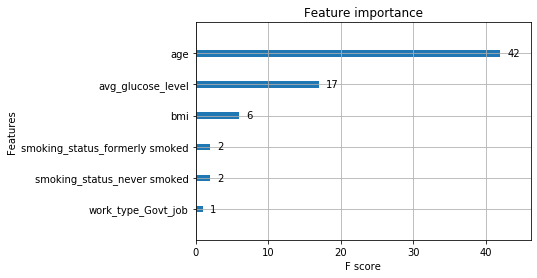

In [39]:
final_model.get_booster().feature_names = attributes
plot_importance(final_model)
plt.show()
# attributes

The most important factors influencing stroke are: **age, bmi and avg_glucose_level**. Howerver, a model here could include **smoking_status**. A further analysis comparing a model with and without smoking_status should be investigated.

## Extension: Over and under sampling techniques were investigated

Here, we are concerned with imbalanced classes data. Given that the size of the data is not too large, I considered the over-sampling technique by essentially randomly selecting a subset of data for the smoke class. This is achieved here by setting the hyperparemeter *over* in the **OverUnderSampling** class defined above, to be True.  Note that by setting it to be False, the under-sampling technique is used.

In [41]:
over_samp = OverUnderSampling(over=True)
X_train, y_train = over_samp.transform(X, y)

## Voting classifier

In [ ]:
log_clf = LogisticRegression(penalty = 'l1')
rnd_clf = RandomForestClassifier()
svm_clf = SVC(probability=True)
tree_clf = DecisionTreeClassifier()
xgb_clf = XGBClassifier()

voting_clf = VotingClassifier(
    estimators=[("lr", log_clf), ("rf", rnd_clf), ("svc", svm_clf), ("dt", tree_clf), ("xb", xgb_clf)],
    voting="soft"
)

voting_clf.fit(X_train, y_train)
scores = []
fpr_s = dict()
tpr_s = dict()
roc_auc = dict()
k = 0
for clf in (log_clf, rnd_clf, tree_clf, svm_clf, xgb_clf, voting_clf):
    clf.fit(X_train, y_train )
    #x_pred = clf.predict(X_train)
    
    pred_test = clf.predict(X_val.values)
    pred_test_probs = clf.predict_proba(X_val.values)
    probs = clf.predict(X_val.values)
    fpr, tpr, thresholds = roc_curve(y_val.values.ravel(),pred_test)
    p,r,t = precision_recall_curve(y_val.values.ravel(),probs)
    fpr_s[k]=fpr
    tpr_s[k]=tpr
    k +=1
    scores.append((clf.__class__.__name__,
                   f1_score(y_val.values.ravel(),pred_test),
                   precision_score(y_val.values.ravel(),pred_test),
                   recall_score(y_val.values.ravel(),pred_test),
                   accuracy_score(y_val.values.ravel(),pred_test),
                   auc(fpr, tpr),
                   auc(p,r,reorder=True),
                   confusion_matrix(y_val.values.ravel(),pred_test)))    #print(clf.__class__.__name__," training:", precision_score(y_train, x_pred),  recall_score(y_train, x_pred) ,f1_score(y_train, x_pred))

In [47]:
sampling_results = pd.DataFrame(scores,columns=['Classifier Type','f1','precision','recall','accuracy','auc_roc','auc_pr','confusion_matrix'])
sampling_results

,Classifier Type,f1,precision,recall,accuracy,auc_roc,auc_pr,confusion_matrix
0,LogisticRegression,0.102663,0.054880,0.794007,0.741237,0.767121,0.407721,"[[10404, 3651], [55, 212]]"
1,RandomForestClassifier,0.074398,0.052550,0.127341,0.940930,0.541863,0.079437,"[[13442, 613], [233, 34]]"
2,DecisionTreeClassifier,0.053488,0.038786,0.086142,0.943164,0.522794,0.052340,"[[13485, 570], [244, 23]]"
3,SVC,0.100169,0.053525,0.779026,0.739073,0.758670,0.399693,"[[10377, 3678], [59, 208]]"
4,XGBClassifier,0.109777,0.060423,0.599251,0.818810,0.711116,0.314930,"[[11567, 2488], [107, 160]]"
5,VotingClassifier,0.112373,0.066856,0.352060,0.896313,0.629356,0.196855,"[[12743, 1312], [173, 94]]"


In [60]:
log_clf = LogisticRegression(penalty = 'l1')
rnd_clf = RandomForestClassifier()
svm_clf = SVC(probability=True)
tree_clf = DecisionTreeClassifier()
xgb_clf = XGBClassifier()

voting_clf = VotingClassifier(
    estimators=[("lr", log_clf), ("rf", rnd_clf), ("svc", svm_clf), ("dt", tree_clf), ("xb", xgb_clf)],
    voting="soft"
)

voting_clf.fit(X_train, y_train)
scores = []
for clf in (log_clf, rnd_clf, tree_clf, svm_clf, xgb_clf, voting_clf):
     clf.cv(X_train, y_train, 5000, nfold=n_folds, early_stopping_rounds=early_stopping, verbose_eval=1)
    #x_pred = clf.predict(X_train)
    
    pred_test = clf.predict(X_train)
    pred_test_probs = clf.predict_proba(X_train)
    probs = clf.predict(X_train)
    fpr, tpr, thresholds = roc_curve(y_train.ravel(),pred_test)
    p,r,t = precision_recall_curve(y_train.ravel(),probs)
    k +=1
    scores.append((clf.__class__.__name__,
                   f1_score(y_train.ravel(),pred_test),
                   precision_score(y_train.ravel(),pred_test),
                   recall_score(y_train.ravel(),pred_test),
                   accuracy_score(y_train.ravel(),pred_test),
                   auc(fpr, tpr),
                   auc(p,r,reorder=True),
                   confusion_matrix(y_train.ravel(),pred_test)))   

In [61]:
sampling_results = pd.DataFrame(scores,columns=['Classifier Type','f1','precision','recall','accuracy','auc_roc','auc_pr','confusion_matrix'])
sampling_results

,Classifier Type,f1,precision,recall,accuracy,auc_roc,auc_pr,confusion_matrix
0,LogisticRegression,0.803126,0.767718,0.841958,0.793607,0.793607,0.344348,"[[21286, 7276], [4514, 24048]]"
1,RandomForestClassifier,0.998407,0.998564,0.998249,0.998407,0.998407,0.498844,"[[28521, 41], [50, 28512]]"
2,DecisionTreeClassifier,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,"[[28562, 0], [0, 28562]]"
3,SVC,0.838459,0.779026,0.907710,0.825117,0.825117,0.366441,"[[21208, 7354], [2636, 25926]]"
4,XGBClassifier,0.868134,0.838168,0.900322,0.863245,0.863245,0.394165,"[[23597, 4965], [2847, 25715]]"
5,VotingClassifier,0.976058,0.961294,0.991282,0.975684,0.975684,0.478468,"[[27422, 1140], [249, 28313]]"


The history saving thread hit an unexpected error (OperationalError('disk I/O error',)).History will not be written to the database.


**XGboost** classifier seems to be an appropriate candidate. Let's find some optimal parameters.

In [165]:
# param_grid = [
#     {"n_estimators": [3, 10, 30], "max_features": [2,4,6,8]},
#     {"bootstrap": [False], "n_estimators": [3,10], "max_features": [2, 3, 4]},
# ]

# xgb_clf = XGBClassifier()
# grid_search = GridSearchCV(xgb_clf, param_grid, cv=5, scoring="")
# y_train_pred = cross_val_predict(xgb_clf, X_train, y_train, cv=3)
# y_test_pred = cross_val_predict(xgb_clf, X_test, y_test, cv=3)
# print(precision_score(y_train_pred, y_train), recall_score(y_train_pred, y_train) ,f1_score(y_train, x_pred))
# print(precision_score(y_test_pred, y_val), recall_score(y_test_pred, y_val), ,f1_score(y_test_pred, y_val) )

# accuracy_score(y_train_pred, y_train)
# confusion_matrix(y_train, y_train_pred)

In [ ]:
fpr, tpr, thresholds = roc_curve(y_val, y_scores)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], "k--")
    plt.axis([0, 1, 0, 1])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    
plot_roc_curve(fpr, tpr)

y_probas_forest = cross_val_predict(rnd_clf, X_val, y_val, cv=3, method="predict_proba")
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_val, y_scores_forest)

y_probas_xgb = cross_val_predict(xgb_clf, X_val, y_val, cv=3, method="predict_proba")
y_scores_xgb = y_probas_xgb[:, 1]
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_val, y_scores_xgb)

plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plot_roc_curve(fpr_xgb, tpr_xgb, "XGBoost")
plt.legend(loc="lower right")
plt.show()